<a href="https://colab.research.google.com/github/tamotamo17/CZII/blob/main/exp036_2_5D_ext_dann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jan 14 20:27:11 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Training base line for [CZII - CryoET Object Identification](https://www.kaggle.com/competitions/czii-cryo-et-object-identification)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-dataset-0-6.zip /content
!unzip -q czii-dataset-0-6.zip -d /content/denoised
!rm czii-dataset-0-6.zip

!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-external-dataset-wbp-0-6.zip /content
!unzip -q czii-external-dataset-wbp-0-6.zip -d /content/ext
!rm czii-external-dataset-wbp-0-6.zip

!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-cryo-et-object-identification.zip /content
!unzip -q czii-cryo-et-object-identification.zip -d /content
!rm czii-cryo-et-object-identification.zip

CPU times: user 2.46 s, sys: 410 ms, total: 2.87 s
Wall time: 9min 13s


In [ ]:
!pip -q install timm
!pip install -q segmentation_models_pytorch
!pip install natsort cupy-cuda12x==13.3.0
!pip install connected-components-3d

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 MB 25.9 MB/s eta 0:00:00
  Attempting uninstall: cupy-cuda12x
    Found existing installation: cupy-cuda12x 12.2.0
    Uninstalling cupy-cuda12x-12.2.0:
      Successfully uninstalled cupy-cuda12x-12.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 82.5 MB/s eta 0:00:00


In [ ]:
DEBUG = False

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/CZII')
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import h5py
from natsort import natsorted
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations as A
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import segmentation_models_pytorch as smp

from src.utils import set_random_seed, color_labeling, convert_to_rgb, convert_to_8bit, create_animation
from src.losses import criterion_seg
from src.metrics import fbeta_score_multiclass, score
from src.datasets import CZII2DDataset
from src.trainer import mixup_dann, train_func_dann, valid_func_dann, inf_func_dann
from src.models import GradientReversalLayer, DASegModel

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Config

In [ ]:
class CFG:
    seed = 42
    kernel_type = 'exp036_2.5D_dann'
    load_kernel = None
    load_last = True
    targets2idx = {'apo-ferritin': 1,
                   'beta-amylase': 2,
                   'beta-galactosidase': 3,
                   'ribosome': 4,
                   'thyroglobulin': 5,
                   'virus-like-particle': 6
                   }
    idx2targets = {1: 'apo-ferritin',
                   2: 'beta-amylase',
                   3: 'beta-galactosidase',
                   4: 'ribosome',
                   5: 'thyroglobulin',
                   6: 'virus-like-particle'
                   }
    colors = [[0, 117, 220],
              [153, 63, 0],
              [76, 0, 92],
              [ 0, 92, 49],
              [43, 206, 72],
              [255, 204, 153],
              ]
    samples = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
               'TS_69_2', 'TS_99_9', 'TS_6_4'
               ]
    n_folds = 4
    backbone = "tu-tf_efficientnet_b0.ns_jft_in1k"#'tf_efficientnetv2_s_in21ft1k' #"tf_efficientnet_b0.ns_jft_in1k" #

    image_size = 640
    indices_ch = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    in_chans = len(indices_ch)
    offset = 1
    direction = 'xy'

    init_lr = 4e-3#1e-3
    eta_min = 1e-7
    batch_size = 16
    drop_rate = 0.
    drop_rate_last = 0.1
    drop_path_rate = 0.
    p_mixup = 1.0
    p_rand_order_v1 = 0#0.2
    mid_range = 0
    p_drop_plane = 0.0
    alpha = 0.05
    beta = 0.95
    loss_weights = [0.5, 0.5, 0.05]#0.05

    data_dir = '/content/hdf5'
    use_amp = True
    num_workers = 4
    num_targets = len(targets2idx)

    n_epochs = 20
    n_epochs_mixup = n_epochs - 10
    save_root = '/content/drive/MyDrive/ColabNotebooks/CZII/results'
    save_dir = os.path.join(save_root, kernel_type)

    log_dir = os.path.join('logs', save_dir)
    model_dir = os.path.join(save_dir, 'models')
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

In [ ]:
set_random_seed(CFG.seed)

In [ ]:
transforms_train = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    A.Resize(CFG.image_size, CFG.image_size),
    #A.RandomBrightness(limit=0.1, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.7),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, border_mode=0, p=0.7),

    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.2),
    # A.OneOf([
    #     A.OpticalDistortion(distort_limit=1.0),
    #     A.GridDistortion(num_steps=5, distort_limit=1.),
    #     A.ElasticTransform(alpha=3),
    # ], p=0.5),

    #A.Cutout(max_h_size=int(CFG.image_size / 8), max_w_size=int(CFG.image_size /8), num_holes=3, p=0.5),
    #A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)), hole_width_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)))
])

transforms_valid = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    A.Resize(CFG.image_size, CFG.image_size),
])

/usr/local/lib/python3.11/dist-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


# DataFrame

In [ ]:
file_paths = glob('/content/denoised/hdf5/*')
data_dicts = {}
df = []
for file_path in file_paths:
    print(file_path)
    base = file_path.split('/')[-1].split('.')[0]
    data = {}
    with h5py.File(file_path, 'r') as f:
        data['image'] = f['image'][:]
        data['label'] = f['label'][:]
    data_dicts[base] = data
    # スライス分のインデックス情報を取得
    num_slices = data['image'].shape[0]

    # データフレーム用のリストに情報を追加
    df_ = []
    for i in range(num_slices):
        df_.append({'sample_name': base, 'slice_index': i})
    df_ = pd.DataFrame(df_)
    df.append(df_)
df = pd.concat(df).reset_index(drop=True)
df['source'] = 'denoised'

/content/denoised/hdf5/TS_69_2.h5
/content/denoised/hdf5/TS_86_3.h5
/content/denoised/hdf5/TS_5_4.h5
/content/denoised/hdf5/TS_6_6.h5
/content/denoised/hdf5/TS_73_6.h5
/content/denoised/hdf5/TS_99_9.h5
/content/denoised/hdf5/TS_6_4.h5


In [ ]:
file_paths_ext = glob('/content/ext/hdf5_wbp/*')
df_ext = []
for file_path in file_paths_ext:
    print(file_path)
    base = file_path.split('/')[-1].split('.')[0]
    data = {}
    with h5py.File(file_path, 'r') as f:
        data['image'] = f['image'][:]
        data['label'] = f['label'][:]
    data_dicts[base] = data
    # スライス分のインデックス情報を取得
    num_slices = data['image'].shape[0]

    # データフレーム用のリストに情報を追加
    df_ = []
    for i in range(num_slices):
        df_.append({'sample_name': base, 'slice_index': i})
    df_ = pd.DataFrame(df_)
    df_ext.append(df_)
df_ext = pd.concat(df_ext).reset_index(drop=True)
df_ext['source'] = 'ext_wbp'

/content/ext/hdf5_wbp/TS_11.h5
/content/ext/hdf5_wbp/TS_18.h5
/content/ext/hdf5_wbp/TS_19.h5
/content/ext/hdf5_wbp/TS_25.h5
/content/ext/hdf5_wbp/TS_17.h5
/content/ext/hdf5_wbp/TS_8.h5
/content/ext/hdf5_wbp/TS_12.h5
/content/ext/hdf5_wbp/TS_20.h5
/content/ext/hdf5_wbp/TS_5.h5
/content/ext/hdf5_wbp/TS_13.h5
/content/ext/hdf5_wbp/TS_3.h5
/content/ext/hdf5_wbp/TS_7.h5
/content/ext/hdf5_wbp/TS_1.h5
/content/ext/hdf5_wbp/TS_6.h5
/content/ext/hdf5_wbp/TS_9.h5
/content/ext/hdf5_wbp/TS_24.h5
/content/ext/hdf5_wbp/TS_22.h5
/content/ext/hdf5_wbp/TS_10.h5
/content/ext/hdf5_wbp/TS_23.h5
/content/ext/hdf5_wbp/TS_2.h5
/content/ext/hdf5_wbp/TS_14.h5
/content/ext/hdf5_wbp/TS_4.h5
/content/ext/hdf5_wbp/TS_0.h5
/content/ext/hdf5_wbp/TS_26.h5
/content/ext/hdf5_wbp/TS_15.h5
/content/ext/hdf5_wbp/TS_16.h5
/content/ext/hdf5_wbp/TS_21.h5


In [ ]:
for key, data in data_dicts.items():
    img = data['image']
    lbl = data['label']
    print(f'{key} image shape: {img.shape}, label shape:{lbl.shape}')
    for i in range(1,7,1):
        print(f'{CFG.idx2targets[i]}: {np.sum(lbl==i)}')
    print('\n')

TS_69_2 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 6846
beta-amylase: 2987
beta-galactosidase: 10558
ribosome: 113014
thyroglobulin: 67594
virus-like-particle: 20046


TS_86_3 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 12476
beta-amylase: 2233
beta-galactosidase: 14519
ribosome: 167985
thyroglobulin: 89354
virus-like-particle: 64304


TS_5_4 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 8984
beta-amylase: 2084
beta-galactosidase: 7969
ribosome: 94638
thyroglobulin: 59545
virus-like-particle: 24521


TS_6_6 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 8024
beta-amylase: 3471
beta-galactosidase: 7266
ribosome: 70334
thyroglobulin: 69619
virus-like-particle: 42275


TS_73_6 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 18429
beta-amylase: 2971
beta-galactosidase: 8696
ribosome: 140607
thyroglobulin: 55642
virus-like-particle: 48934


TS_99_9 image shape:

# Dataset

In [ ]:
data_dicts.keys()

dict_keys(['TS_69_2', 'TS_86_3', 'TS_5_4', 'TS_6_6', 'TS_73_6', 'TS_99_9', 'TS_6_4', 'TS_11', 'TS_18', 'TS_19', 'TS_25', 'TS_17', 'TS_8', 'TS_12', 'TS_20', 'TS_5', 'TS_13', 'TS_3', 'TS_7', 'TS_1', 'TS_6', 'TS_9', 'TS_24', 'TS_22', 'TS_10', 'TS_23', 'TS_2', 'TS_14', 'TS_4', 'TS_0', 'TS_26', 'TS_15', 'TS_16', 'TS_21'])

In [ ]:
df['fold'] = -1
df_ext['fold'] = -1
for fold, sample_name in enumerate(CFG.samples):
    df.loc[df['sample_name']==sample_name, 'fold'] = fold
df

,sample_name,slice_index,source,fold
0,TS_69_2,0,denoised,4
1,TS_69_2,1,denoised,4
2,TS_69_2,2,denoised,4
3,TS_69_2,3,denoised,4
4,TS_69_2,4,denoised,4
...,...,...,...,...
1283,TS_6_4,179,denoised,6
1284,TS_6_4,180,denoised,6
1285,TS_6_4,181,denoised,6
1286,TS_6_4,182,denoised,6


In [ ]:
df = pd.concat([df, df_ext]).reset_index(drop=True)

In [ ]:
len(data_dicts)

34

In [ ]:
from collections import Counter
labels = df["source"].values

# Counter を用いて各クラスの出現数をカウント
label_counts = Counter(labels)
# 例：{0: 4, 1: 3, 2: 3} のような結果

# 各クラスの重みは、出現数の逆数として計算
class_weights = {label: 1.0/count for label, count in label_counts.items()}

# DataFrame の各行に対応する重みリストを作成
sample_weights = [class_weights[label] for label in labels]
# Tensor に変換（float型推奨）
sample_weights = torch.DoubleTensor(sample_weights)

# WeightedRandomSampler の作成
sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)
df_show = df
dataset_show = CZII2DDataset(df_show,
                             data_dicts,
                             CFG.indices_ch,
                             direction=CFG.direction,
                             mode='train',
                             transform=transforms_train
                             )
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=CFG.batch_size, sampler=sampler, shuffle=False, num_workers=CFG.num_workers)

torch.Size([16, 11, 640, 640]) torch.Size([16, 640, 640])


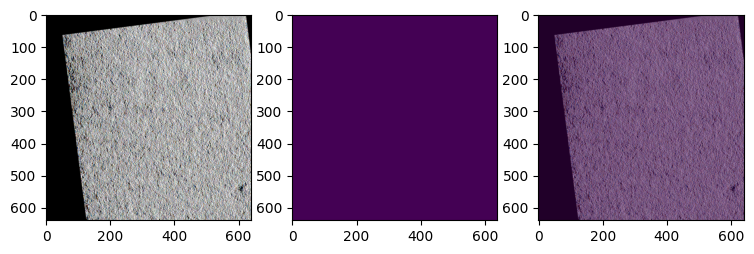

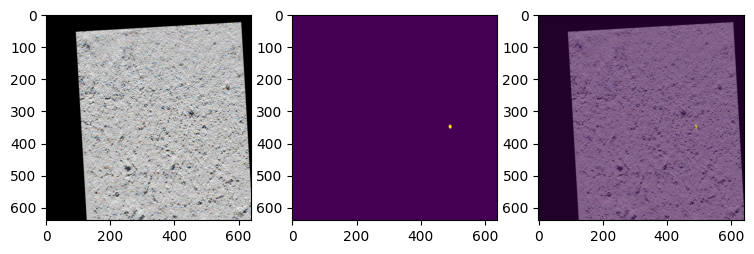

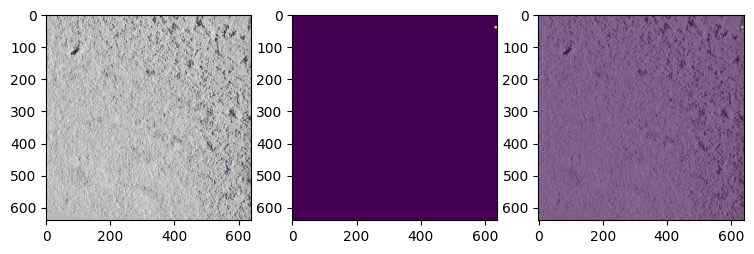

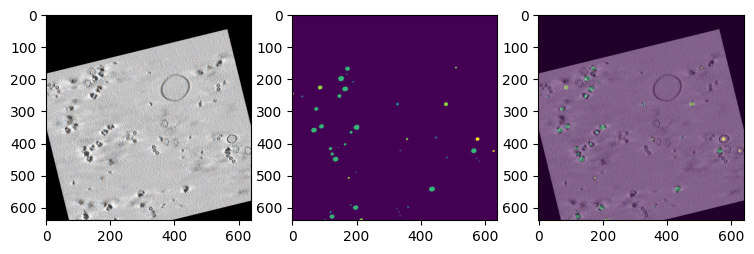

In [ ]:
for data in loader_show:
    imgs = data['image']
    label = data['label']
    source = data['source']
    for p in range(4):
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,1:4])
        plt.subplot(1,3,2)
        plt.imshow(label[p])
        plt.subplot(1,3,3)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,1:4])
        plt.imshow(label[p], alpha=0.5)
    break
print(imgs.shape, label.shape)

In [ ]:
source

tensor([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.])

In [ ]:
imgs[p].shape, label.dtype

(torch.Size([11, 640, 640]), torch.int64)

In [ ]:
torch.unique(label)

tensor([0, 1, 2, 3, 4, 5, 6])

# Loss & Metric

# Training

In [ ]:
df[df['fold'] != fold].reset_index(drop=True)

,sample_name,slice_index,source,fold
0,TS_69_2,0,denoised,4
1,TS_69_2,1,denoised,4
2,TS_69_2,2,denoised,4
3,TS_69_2,3,denoised,4
4,TS_69_2,4,denoised,4
...,...,...,...,...
6499,TS_21,195,ext_wbp,-1
6500,TS_21,196,ext_wbp,-1
6501,TS_21,197,ext_wbp,-1
6502,TS_21,198,ext_wbp,-1


In [ ]:
def run(fold):

    log_file = os.path.join(CFG.log_dir, f'{CFG.kernel_type}.txt')
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')

    train_ = df[(df['fold'] != fold)].reset_index(drop=True)
    valid_ = df[(df['fold'] == fold)&(df['source'] == 'denoised')].reset_index(drop=True)

    labels = train_["source"].values
    # Counter を用いて各クラスの出現数をカウント
    label_counts = Counter(labels)
    # 各クラスの重みは、出現数の逆数として計算
    class_weights = {label: 1.0/count for label, count in label_counts.items()}
    sample_weights = [class_weights[label] for label in labels]
    sample_weights = torch.DoubleTensor(sample_weights)

    # WeightedRandomSampler の作成
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples=len(sample_weights)//4,
                                    replacement=True)
    dataset_train = CZII2DDataset(train_,
                                  data_dicts,
                                  CFG.indices_ch,
                                  direction=CFG.direction,
                                  mode='train',
                                  transform=transforms_train
                                  )
    dataset_valid = CZII2DDataset(valid_,
                                  data_dicts,
                                  CFG.indices_ch,
                                  direction=CFG.direction,
                                  mode='valid',
                                  transform=transforms_valid
                                  )
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, sampler=sampler,
                                               shuffle=False, num_workers=CFG.num_workers, drop_last=True
                                               )
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size,
                                               shuffle=False, num_workers=CFG.num_workers
                                               )
    print(len(loader_train))

    model = DASegModel(CFG.backbone, CFG.in_chans,
                       out_chans=7, out_chans_domain=1
                       )
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None

    metric_best = -np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)
        # model, loader_train, optimizer,
        #        alpha, beta, loss_weights,
        #        p_mixup, n_epochs_mixup, epoch, num_epoch,
        #        device, scaler=None

        train_loss = train_func_dann(model, loader_train, optimizer, alpha=CFG.alpha, beta=CFG.beta,
                                     loss_weights=CFG.loss_weights, p_mixup=CFG.p_mixup, n_epochs_mixup=CFG.n_epochs_mixup,
                                     epoch=epoch, n_epochs=CFG.n_epochs, device=device, scaler=scaler
                                     )
        valid_loss, valid_loss_bce, valid_loss_tvs, valid_loss_domain, valid_score = valid_func_dann(model, loader_valid,
                                                                                  alpha=CFG.alpha, beta=CFG.beta,
                                                                                  loss_weights=CFG.loss_weights,
                                                                                  device=device
                                                                                  )
        metric = valid_score

        content = (
            f"{time.ctime()} "
            f"Fold {fold}, "
            f"Epoch {epoch}, "
            f"lr: {optimizer.param_groups[0]['lr']:.7f}, "
            f"train loss: {train_loss:.5f}, \n"
            f"valid loss: {valid_loss:.5f}, "
            f"valid loss bce: {valid_loss_bce:.5f}, "
            f"valid loss tvs: {valid_loss_tvs:.5f}, "
            f"valid loss domain: {valid_loss_domain:.5f}, "
            f"metric: {metric:.6f}, "
            f"valid f4: {valid_score:.4f}, "
        )

        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()
    return metric_best

def run_inference(fold, size):
    log_file = os.path.join(CFG.log_dir, f'{CFG.kernel_type}.txt')
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')

    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_valid = CZII2DDataset(valid_,
                                  data_dicts,
                                  CFG.indices_ch,
                                  direction=CFG.direction,
                                  mode='valid', transform=transforms_valid
                                  )
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
    model = DASegModel(CFG.backbone, CFG.in_chans,
                       out_chans=7, out_chans_domain=1
                       )
    model.load_state_dict(torch.load(model_file))
    model = model.eval().to(device)
    gts, outputs = inf_func_dann(model, loader_valid, size, device)
    return gts, outputs



In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [0, 1, 2]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)
    print(best_scores)
    print(np.mean(best_scores))

101


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


6504 184
Wed Jan 15 01:32:51 2025 Epoch: 1


<ipython-input-20-808793a8378a>:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None
  0%|          | 0/101 [00:00<?, ?it/s]/content/drive/MyDrive/ColabNotebooks/CZII/src/trainer.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
smth:0.4808: 100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


Wed Jan 15 01:35:17 2025 Fold 0, Epoch 1, lr: 0.0040000, train loss: 0.61625, 
valid loss: 0.48080, valid loss bce: 0.00963, valid loss tvs: 0.29361, valid loss domain: 3.55119, metric: 0.008540, valid f4: 0.0085, 
metric_best (-inf --> 0.008540). Saving model ...
Wed Jan 15 01:35:17 2025 Epoch: 2


smth:0.2415: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 01:37:15 2025 Fold 0, Epoch 2, lr: 0.0039754, train loss: 0.49894, 
valid loss: 0.24150, valid loss bce: 0.01376, valid loss tvs: 0.22774, valid loss domain: 0.00004, metric: 0.277315, valid f4: 0.2773, 
metric_best (0.008540 --> 0.277315). Saving model ...
Wed Jan 15 01:37:15 2025 Epoch: 3


smth:0.1988: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Wed Jan 15 01:39:14 2025 Fold 0, Epoch 3, lr: 0.0039021, train loss: 0.42170, 
valid loss: 0.19885, valid loss bce: 0.01523, valid loss tvs: 0.17782, valid loss domain: 0.11588, metric: 0.413432, valid f4: 0.4134, 
metric_best (0.277315 --> 0.413432). Saving model ...
Wed Jan 15 01:39:14 2025 Epoch: 4


smth:0.1763: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 01:41:12 2025 Fold 0, Epoch 4, lr: 0.0037820, train loss: 0.32298, 
valid loss: 0.17628, valid loss bce: 0.01659, valid loss tvs: 0.14678, valid loss domain: 0.25815, metric: 0.504351, valid f4: 0.5044, 
metric_best (0.413432 --> 0.504351). Saving model ...
Wed Jan 15 01:41:13 2025 Epoch: 5


smth:1.5213: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 01:43:11 2025 Fold 0, Epoch 5, lr: 0.0036180, train loss: 0.36775, 
valid loss: 1.52131, valid loss bce: 0.01198, valid loss tvs: 0.14669, valid loss domain: 27.25274, metric: 0.508598, valid f4: 0.5086, 
metric_best (0.504351 --> 0.508598). Saving model ...
Wed Jan 15 01:43:12 2025 Epoch: 6


smth:2.4606: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 01:45:09 2025 Fold 0, Epoch 6, lr: 0.0034142, train loss: 0.96783, 
valid loss: 2.46063, valid loss bce: 0.01820, valid loss tvs: 0.13905, valid loss domain: 46.06767, metric: 0.534219, valid f4: 0.5342, 
metric_best (0.508598 --> 0.534219). Saving model ...
Wed Jan 15 01:45:10 2025 Epoch: 7


smth:0.1777: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 01:47:08 2025 Fold 0, Epoch 7, lr: 0.0031756, train loss: 0.55905, 
valid loss: 0.17768, valid loss bce: 0.01082, valid loss tvs: 0.11806, valid loss domain: 0.97594, metric: 0.605755, valid f4: 0.6058, 
metric_best (0.534219 --> 0.605755). Saving model ...
Wed Jan 15 01:47:08 2025 Epoch: 8


smth:0.4896: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 01:49:06 2025 Fold 0, Epoch 8, lr: 0.0029080, train loss: 0.38909, 
valid loss: 0.48958, valid loss bce: 0.01869, valid loss tvs: 0.12749, valid loss domain: 6.86797, metric: 0.574920, valid f4: 0.5749, 
Wed Jan 15 01:49:06 2025 Epoch: 9


smth:0.8504: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Wed Jan 15 01:51:04 2025 Fold 0, Epoch 9, lr: 0.0026181, train loss: 0.58534, 
valid loss: 0.85044, valid loss bce: 0.01187, valid loss tvs: 0.11970, valid loss domain: 14.37734, metric: 0.605033, valid f4: 0.6050, 
Wed Jan 15 01:51:05 2025 Epoch: 10


smth:1.3530: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 01:52:59 2025 Fold 0, Epoch 10, lr: 0.0023129, train loss: 0.92976, 
valid loss: 1.35302, valid loss bce: 0.00986, valid loss tvs: 0.12037, valid loss domain: 24.45584, metric: 0.586228, valid f4: 0.5862, 
Wed Jan 15 01:53:00 2025 Epoch: 11


smth:0.1663: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 01:54:54 2025 Fold 0, Epoch 11, lr: 0.0020000, train loss: 0.40266, 
valid loss: 0.16629, valid loss bce: 0.01593, valid loss tvs: 0.11719, valid loss domain: 0.66340, metric: 0.612585, valid f4: 0.6126, 
metric_best (0.605755 --> 0.612585). Saving model ...
Wed Jan 15 01:54:55 2025 Epoch: 12


smth:0.1617: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 01:56:49 2025 Fold 0, Epoch 12, lr: 0.0016872, train loss: 0.20195, 
valid loss: 0.16167, valid loss bce: 0.01225, valid loss tvs: 0.10935, valid loss domain: 0.80150, metric: 0.628825, valid f4: 0.6288, 
metric_best (0.612585 --> 0.628825). Saving model ...
Wed Jan 15 01:56:50 2025 Epoch: 13


smth:0.1434: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


Wed Jan 15 01:58:44 2025 Fold 0, Epoch 13, lr: 0.0013820, train loss: 0.18611, 
valid loss: 0.14340, valid loss bce: 0.01411, valid loss tvs: 0.10827, valid loss domain: 0.42037, metric: 0.637059, valid f4: 0.6371, 
metric_best (0.628825 --> 0.637059). Saving model ...
Wed Jan 15 01:58:44 2025 Epoch: 14


smth:0.1522: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Wed Jan 15 02:00:38 2025 Fold 0, Epoch 14, lr: 0.0010921, train loss: 0.17260, 
valid loss: 0.15216, valid loss bce: 0.01474, valid loss tvs: 0.10404, valid loss domain: 0.66772, metric: 0.653812, valid f4: 0.6538, 
metric_best (0.637059 --> 0.653812). Saving model ...
Wed Jan 15 02:00:38 2025 Epoch: 15


smth:0.1594: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:02:31 2025 Fold 0, Epoch 15, lr: 0.0008245, train loss: 0.17451, 
valid loss: 0.15936, valid loss bce: 0.01400, valid loss tvs: 0.10389, valid loss domain: 0.82947, metric: 0.648912, valid f4: 0.6489, 
Wed Jan 15 02:02:32 2025 Epoch: 16


smth:0.1464: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:04:25 2025 Fold 0, Epoch 16, lr: 0.0005859, train loss: 0.17354, 
valid loss: 0.14644, valid loss bce: 0.01153, valid loss tvs: 0.10153, valid loss domain: 0.66756, metric: 0.661500, valid f4: 0.6615, 
metric_best (0.653812 --> 0.661500). Saving model ...
Wed Jan 15 02:04:25 2025 Epoch: 17


smth:0.1549: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 02:06:18 2025 Fold 0, Epoch 17, lr: 0.0003821, train loss: 0.16923, 
valid loss: 0.15488, valid loss bce: 0.01495, valid loss tvs: 0.09972, valid loss domain: 0.80417, metric: 0.662248, valid f4: 0.6622, 
metric_best (0.661500 --> 0.662248). Saving model ...
Wed Jan 15 02:06:19 2025 Epoch: 18


smth:0.1384: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 02:08:12 2025 Fold 0, Epoch 18, lr: 0.0002181, train loss: 0.16861, 
valid loss: 0.13842, valid loss bce: 0.01202, valid loss tvs: 0.09963, valid loss domain: 0.53535, metric: 0.666522, valid f4: 0.6665, 
metric_best (0.662248 --> 0.666522). Saving model ...
Wed Jan 15 02:08:12 2025 Epoch: 19


smth:0.1451: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 02:10:07 2025 Fold 0, Epoch 19, lr: 0.0000980, train loss: 0.16657, 
valid loss: 0.14514, valid loss bce: 0.01365, valid loss tvs: 0.09912, valid loss domain: 0.64733, metric: 0.666992, valid f4: 0.6670, 
metric_best (0.666522 --> 0.666992). Saving model ...
Wed Jan 15 02:10:07 2025 Epoch: 20


smth:0.1393: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Wed Jan 15 02:12:00 2025 Fold 0, Epoch 20, lr: 0.0000247, train loss: 0.16418, 
valid loss: 0.13933, valid loss bce: 0.01244, valid loss tvs: 0.09896, valid loss domain: 0.55877, metric: 0.670007, valid f4: 0.6700, 
metric_best (0.666992 --> 0.670007). Saving model ...
101


6504 184
Wed Jan 15 02:12:02 2025 Epoch: 1


smth:0.6291: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 02:14:00 2025 Fold 1, Epoch 1, lr: 0.0040000, train loss: 0.62258, 
valid loss: 0.62909, valid loss bce: 0.01735, valid loss tvs: 0.22314, valid loss domain: 7.77190, metric: 0.000000, valid f4: 0.0000, 
metric_best (-inf --> 0.000000). Saving model ...
Wed Jan 15 02:14:04 2025 Epoch: 2


smth:0.2707: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 02:16:03 2025 Fold 1, Epoch 2, lr: 0.0039754, train loss: 0.52107, 
valid loss: 0.27075, valid loss bce: 0.01646, valid loss tvs: 0.17223, valid loss domain: 1.64121, metric: 0.237880, valid f4: 0.2379, 
metric_best (0.000000 --> 0.237880). Saving model ...
Wed Jan 15 02:16:03 2025 Epoch: 3


smth:0.1462: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:18:01 2025 Fold 1, Epoch 3, lr: 0.0039021, train loss: 0.38358, 
valid loss: 0.14618, valid loss bce: 0.02144, valid loss tvs: 0.12119, valid loss domain: 0.07106, metric: 0.451382, valid f4: 0.4514, 
metric_best (0.237880 --> 0.451382). Saving model ...
Wed Jan 15 02:18:01 2025 Epoch: 4


smth:0.1955: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Wed Jan 15 02:19:59 2025 Fold 1, Epoch 4, lr: 0.0037820, train loss: 0.28335, 
valid loss: 0.19553, valid loss bce: 0.02035, valid loss tvs: 0.10179, valid loss domain: 1.46781, metric: 0.541519, valid f4: 0.5415, 
metric_best (0.451382 --> 0.541519). Saving model ...
Wed Jan 15 02:20:00 2025 Epoch: 5


smth:0.1700: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:21:57 2025 Fold 1, Epoch 5, lr: 0.0036180, train loss: 0.57843, 
valid loss: 0.16999, valid loss bce: 0.02246, valid loss tvs: 0.09848, valid loss domain: 0.98084, metric: 0.584592, valid f4: 0.5846, 
metric_best (0.541519 --> 0.584592). Saving model ...
Wed Jan 15 02:21:58 2025 Epoch: 6


smth:0.1149: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Wed Jan 15 02:23:56 2025 Fold 1, Epoch 6, lr: 0.0034142, train loss: 0.61900, 
valid loss: 0.11487, valid loss bce: 0.01789, valid loss tvs: 0.09356, valid loss domain: 0.06858, metric: 0.611101, valid f4: 0.6111, 
metric_best (0.584592 --> 0.611101). Saving model ...
Wed Jan 15 02:23:57 2025 Epoch: 7


smth:0.1890: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:25:55 2025 Fold 1, Epoch 7, lr: 0.0031756, train loss: 0.28857, 
valid loss: 0.18896, valid loss bce: 0.02963, valid loss tvs: 0.09609, valid loss domain: 1.26480, metric: 0.610451, valid f4: 0.6105, 
Wed Jan 15 02:25:55 2025 Epoch: 8


smth:0.1195: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


Wed Jan 15 02:27:53 2025 Fold 1, Epoch 8, lr: 0.0029080, train loss: 0.26072, 
valid loss: 0.11954, valid loss bce: 0.01681, valid loss tvs: 0.09130, valid loss domain: 0.22851, metric: 0.614977, valid f4: 0.6150, 
metric_best (0.611101 --> 0.614977). Saving model ...
Wed Jan 15 02:27:53 2025 Epoch: 9


smth:0.1374: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:29:51 2025 Fold 1, Epoch 9, lr: 0.0026181, train loss: 0.25169, 
valid loss: 0.13743, valid loss bce: 0.01881, valid loss tvs: 0.08459, valid loss domain: 0.68055, metric: 0.648119, valid f4: 0.6481, 
metric_best (0.614977 --> 0.648119). Saving model ...
Wed Jan 15 02:29:51 2025 Epoch: 10


smth:0.1436: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 02:31:43 2025 Fold 1, Epoch 10, lr: 0.0023129, train loss: 0.18894, 
valid loss: 0.14363, valid loss bce: 0.01365, valid loss tvs: 0.08476, valid loss domain: 0.90435, metric: 0.631127, valid f4: 0.6311, 
Wed Jan 15 02:31:44 2025 Epoch: 11


smth:0.1538: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:33:37 2025 Fold 1, Epoch 11, lr: 0.0020000, train loss: 0.18725, 
valid loss: 0.15383, valid loss bce: 0.01598, valid loss tvs: 0.08807, valid loss domain: 0.99564, metric: 0.617041, valid f4: 0.6170, 
Wed Jan 15 02:33:37 2025 Epoch: 12


smth:0.1303: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 02:35:31 2025 Fold 1, Epoch 12, lr: 0.0016872, train loss: 0.18415, 
valid loss: 0.13032, valid loss bce: 0.01889, valid loss tvs: 0.07908, valid loss domain: 0.64705, metric: 0.655814, valid f4: 0.6558, 
metric_best (0.648119 --> 0.655814). Saving model ...
Wed Jan 15 02:35:32 2025 Epoch: 13


smth:0.1225: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:37:25 2025 Fold 1, Epoch 13, lr: 0.0013820, train loss: 0.17239, 
valid loss: 0.12252, valid loss bce: 0.01405, valid loss tvs: 0.08889, valid loss domain: 0.39147, metric: 0.616085, valid f4: 0.6161, 
Wed Jan 15 02:37:25 2025 Epoch: 14


smth:0.1159: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:39:18 2025 Fold 1, Epoch 14, lr: 0.0010921, train loss: 0.17480, 
valid loss: 0.11590, valid loss bce: 0.01552, valid loss tvs: 0.07735, valid loss domain: 0.46064, metric: 0.665130, valid f4: 0.6651, 
metric_best (0.655814 --> 0.665130). Saving model ...
Wed Jan 15 02:39:19 2025 Epoch: 15


smth:0.1457: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Wed Jan 15 02:41:12 2025 Fold 1, Epoch 15, lr: 0.0008245, train loss: 0.16828, 
valid loss: 0.14568, valid loss bce: 0.01605, valid loss tvs: 0.07713, valid loss domain: 1.05013, metric: 0.665764, valid f4: 0.6658, 
metric_best (0.665130 --> 0.665764). Saving model ...
Wed Jan 15 02:41:13 2025 Epoch: 16


smth:0.1337: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:43:06 2025 Fold 1, Epoch 16, lr: 0.0005859, train loss: 0.16909, 
valid loss: 0.13365, valid loss bce: 0.01404, valid loss tvs: 0.08063, valid loss domain: 0.77960, metric: 0.662381, valid f4: 0.6624, 
Wed Jan 15 02:43:06 2025 Epoch: 17


smth:0.1322: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:45:00 2025 Fold 1, Epoch 17, lr: 0.0003821, train loss: 0.16122, 
valid loss: 0.13215, valid loss bce: 0.01609, valid loss tvs: 0.07649, valid loss domain: 0.79141, metric: 0.678618, valid f4: 0.6786, 
metric_best (0.665764 --> 0.678618). Saving model ...
Wed Jan 15 02:45:00 2025 Epoch: 18


smth:0.1285: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:46:53 2025 Fold 1, Epoch 18, lr: 0.0002181, train loss: 0.16116, 
valid loss: 0.12850, valid loss bce: 0.01602, valid loss tvs: 0.07753, valid loss domain: 0.69895, metric: 0.667320, valid f4: 0.6673, 
Wed Jan 15 02:46:54 2025 Epoch: 19


smth:0.1302: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:48:47 2025 Fold 1, Epoch 19, lr: 0.0000980, train loss: 0.16103, 
valid loss: 0.13025, valid loss bce: 0.01583, valid loss tvs: 0.07903, valid loss domain: 0.70777, metric: 0.674022, valid f4: 0.6740, 
Wed Jan 15 02:48:47 2025 Epoch: 20


smth:0.1294: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:50:42 2025 Fold 1, Epoch 20, lr: 0.0000247, train loss: 0.15829, 
valid loss: 0.12942, valid loss bce: 0.01483, valid loss tvs: 0.07960, valid loss domain: 0.69982, metric: 0.665059, valid f4: 0.6651, 
101


6504 184
Wed Jan 15 02:50:44 2025 Epoch: 1


smth:0.3116: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 02:52:42 2025 Fold 2, Epoch 1, lr: 0.0040000, train loss: 0.66827, 
valid loss: 0.31163, valid loss bce: 0.01151, valid loss tvs: 0.26476, valid loss domain: 0.70722, metric: 0.000000, valid f4: 0.0000, 
metric_best (-inf --> 0.000000). Saving model ...
Wed Jan 15 02:52:46 2025 Epoch: 2


smth:0.2544: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:54:45 2025 Fold 2, Epoch 2, lr: 0.0039754, train loss: 0.57261, 
valid loss: 0.25436, valid loss bce: 0.00970, valid loss tvs: 0.23837, valid loss domain: 0.12592, metric: 0.100016, valid f4: 0.1000, 
metric_best (0.000000 --> 0.100016). Saving model ...
Wed Jan 15 02:54:45 2025 Epoch: 3


smth:0.3057: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 02:56:43 2025 Fold 2, Epoch 3, lr: 0.0039021, train loss: 0.48129, 
valid loss: 0.30568, valid loss bce: 0.01253, valid loss tvs: 0.19086, valid loss domain: 2.04565, metric: 0.320117, valid f4: 0.3201, 
metric_best (0.100016 --> 0.320117). Saving model ...
Wed Jan 15 02:56:44 2025 Epoch: 4


smth:2.1853: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 02:58:42 2025 Fold 2, Epoch 4, lr: 0.0037820, train loss: 0.57843, 
valid loss: 2.18528, valid loss bce: 0.01233, valid loss tvs: 0.16855, valid loss domain: 40.08791, metric: 0.356215, valid f4: 0.3562, 
metric_best (0.320117 --> 0.356215). Saving model ...
Wed Jan 15 02:58:43 2025 Epoch: 5


smth:0.1572: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:00:41 2025 Fold 2, Epoch 5, lr: 0.0036180, train loss: 0.38915, 
valid loss: 0.15725, valid loss bce: 0.01766, valid loss tvs: 0.13958, valid loss domain: 0.00009, metric: 0.495146, valid f4: 0.4951, 
metric_best (0.356215 --> 0.495146). Saving model ...
Wed Jan 15 03:00:41 2025 Epoch: 6


smth:0.1585: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:02:40 2025 Fold 2, Epoch 6, lr: 0.0034142, train loss: 0.30116, 
valid loss: 0.15849, valid loss bce: 0.02145, valid loss tvs: 0.12132, valid loss domain: 0.31424, metric: 0.534404, valid f4: 0.5344, 
metric_best (0.495146 --> 0.534404). Saving model ...
Wed Jan 15 03:02:40 2025 Epoch: 7


smth:0.1816: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Wed Jan 15 03:04:38 2025 Fold 2, Epoch 7, lr: 0.0031756, train loss: 0.35407, 
valid loss: 0.18158, valid loss bce: 0.01826, valid loss tvs: 0.11820, valid loss domain: 0.90234, metric: 0.584583, valid f4: 0.5846, 
metric_best (0.534404 --> 0.584583). Saving model ...
Wed Jan 15 03:04:39 2025 Epoch: 8


smth:0.8245: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Wed Jan 15 03:06:37 2025 Fold 2, Epoch 8, lr: 0.0029080, train loss: 0.46723, 
valid loss: 0.82446, valid loss bce: 0.02090, valid loss tvs: 0.11149, valid loss domain: 13.84146, metric: 0.589703, valid f4: 0.5897, 
metric_best (0.584583 --> 0.589703). Saving model ...
Wed Jan 15 03:06:37 2025 Epoch: 9


smth:0.3008: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 03:08:35 2025 Fold 2, Epoch 9, lr: 0.0026181, train loss: 0.55116, 
valid loss: 0.30083, valid loss bce: 0.01720, valid loss tvs: 0.13543, valid loss domain: 2.96386, metric: 0.486453, valid f4: 0.4865, 
Wed Jan 15 03:08:35 2025 Epoch: 10


smth:0.1596: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 03:10:29 2025 Fold 2, Epoch 10, lr: 0.0023129, train loss: 0.22886, 
valid loss: 0.15960, valid loss bce: 0.01565, valid loss tvs: 0.10637, valid loss domain: 0.75167, metric: 0.601995, valid f4: 0.6020, 
metric_best (0.589703 --> 0.601995). Saving model ...
Wed Jan 15 03:10:29 2025 Epoch: 11


smth:0.1505: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 03:12:23 2025 Fold 2, Epoch 11, lr: 0.0020000, train loss: 0.18647, 
valid loss: 0.15048, valid loss bce: 0.01325, valid loss tvs: 0.10498, valid loss domain: 0.64476, metric: 0.607310, valid f4: 0.6073, 
metric_best (0.601995 --> 0.607310). Saving model ...
Wed Jan 15 03:12:24 2025 Epoch: 12


smth:0.1487: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 03:14:18 2025 Fold 2, Epoch 12, lr: 0.0016872, train loss: 0.18721, 
valid loss: 0.14873, valid loss bce: 0.01579, valid loss tvs: 0.10415, valid loss domain: 0.57584, metric: 0.602608, valid f4: 0.6026, 
Wed Jan 15 03:14:18 2025 Epoch: 13


smth:0.1842: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:16:11 2025 Fold 2, Epoch 13, lr: 0.0013820, train loss: 0.18251, 
valid loss: 0.18420, valid loss bce: 0.01843, valid loss tvs: 0.10281, valid loss domain: 1.25917, metric: 0.609108, valid f4: 0.6091, 
metric_best (0.607310 --> 0.609108). Saving model ...
Wed Jan 15 03:16:12 2025 Epoch: 14


smth:0.1541: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 03:18:04 2025 Fold 2, Epoch 14, lr: 0.0010921, train loss: 0.22795, 
valid loss: 0.15410, valid loss bce: 0.01248, valid loss tvs: 0.10180, valid loss domain: 0.79631, metric: 0.623722, valid f4: 0.6237, 
metric_best (0.609108 --> 0.623722). Saving model ...
Wed Jan 15 03:18:05 2025 Epoch: 15


smth:0.1650: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Wed Jan 15 03:19:58 2025 Fold 2, Epoch 15, lr: 0.0008245, train loss: 0.20937, 
valid loss: 0.16501, valid loss bce: 0.01652, valid loss tvs: 0.09880, valid loss domain: 0.99385, metric: 0.632425, valid f4: 0.6324, 
metric_best (0.623722 --> 0.632425). Saving model ...
Wed Jan 15 03:19:58 2025 Epoch: 16


smth:0.1604: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 03:21:51 2025 Fold 2, Epoch 16, lr: 0.0005859, train loss: 0.18137, 
valid loss: 0.16039, valid loss bce: 0.01689, valid loss tvs: 0.09786, valid loss domain: 0.91277, metric: 0.640156, valid f4: 0.6402, 
metric_best (0.632425 --> 0.640156). Saving model ...
Wed Jan 15 03:21:52 2025 Epoch: 17


smth:0.1665: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:23:45 2025 Fold 2, Epoch 17, lr: 0.0003821, train loss: 0.16031, 
valid loss: 0.16649, valid loss bce: 0.01700, valid loss tvs: 0.09790, valid loss domain: 1.03193, metric: 0.633649, valid f4: 0.6336, 
Wed Jan 15 03:23:45 2025 Epoch: 18


smth:0.1486: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:25:38 2025 Fold 2, Epoch 18, lr: 0.0002181, train loss: 0.16564, 
valid loss: 0.14858, valid loss bce: 0.01476, valid loss tvs: 0.09583, valid loss domain: 0.75999, metric: 0.647145, valid f4: 0.6471, 
metric_best (0.640156 --> 0.647145). Saving model ...
Wed Jan 15 03:25:39 2025 Epoch: 19


smth:0.1476: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 03:27:32 2025 Fold 2, Epoch 19, lr: 0.0000980, train loss: 0.16060, 
valid loss: 0.14765, valid loss bce: 0.01384, valid loss tvs: 0.09643, valid loss domain: 0.74761, metric: 0.643385, valid f4: 0.6434, 
Wed Jan 15 03:27:33 2025 Epoch: 20


smth:0.1463: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 03:29:27 2025 Fold 2, Epoch 20, lr: 0.0000247, train loss: 0.16184, 
valid loss: 0.14632, valid loss bce: 0.01376, valid loss tvs: 0.09599, valid loss domain: 0.73126, metric: 0.647202, valid f4: 0.6472, 
metric_best (0.647145 --> 0.647202). Saving model ...
[0.6700065407006833, 0.6786183914533132, 0.6472021339025663]
0.6652756886855209


In [ ]:

RUN_TRAIN = True
if RUN_TRAIN:
    folds = [3, 4, 5, 6]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)
    print(best_scores)
    print(np.mean(best_scores))

[autoreload of src.models failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.11/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
       ^^^^^^^^^^^^^^^^^^

101


6504 184
Wed Jan 15 03:39:46 2025 Epoch: 1


<ipython-input-20-808793a8378a>:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None
smth:0.5430: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 03:41:44 2025 Fold 3, Epoch 1, lr: 0.0040000, train loss: 0.63240, 
valid loss: 0.54299, valid loss bce: 0.01585, valid loss tvs: 0.23036, valid loss domain: 5.93565, metric: 0.085328, valid f4: 0.0853, 
metric_best (-inf --> 0.085328). Saving model ...
Wed Jan 15 03:41:45 2025 Epoch: 2


smth:0.1808: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:43:43 2025 Fold 3, Epoch 2, lr: 0.0039754, train loss: 0.46967, 
valid loss: 0.18084, valid loss bce: 0.01106, valid loss tvs: 0.16731, valid loss domain: 0.04954, metric: 0.265354, valid f4: 0.2654, 
metric_best (0.085328 --> 0.265354). Saving model ...
Wed Jan 15 03:43:44 2025 Epoch: 3


smth:0.4365: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:45:41 2025 Fold 3, Epoch 3, lr: 0.0039021, train loss: 0.41432, 
valid loss: 0.43645, valid loss bce: 0.01343, valid loss tvs: 0.13145, valid loss domain: 5.83138, metric: 0.400590, valid f4: 0.4006, 
metric_best (0.265354 --> 0.400590). Saving model ...
Wed Jan 15 03:45:42 2025 Epoch: 4


smth:0.1426: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:47:39 2025 Fold 3, Epoch 4, lr: 0.0037820, train loss: 0.63291, 
valid loss: 0.14259, valid loss bce: 0.00953, valid loss tvs: 0.13306, valid loss domain: 0.00000, metric: 0.410419, valid f4: 0.4104, 
metric_best (0.400590 --> 0.410419). Saving model ...
Wed Jan 15 03:47:40 2025 Epoch: 5


smth:0.1259: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 03:49:37 2025 Fold 3, Epoch 5, lr: 0.0036180, train loss: 0.47206, 
valid loss: 0.12591, valid loss bce: 0.01274, valid loss tvs: 0.10262, valid loss domain: 0.21110, metric: 0.558176, valid f4: 0.5582, 
metric_best (0.410419 --> 0.558176). Saving model ...
Wed Jan 15 03:49:38 2025 Epoch: 6


smth:0.2361: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 03:51:35 2025 Fold 3, Epoch 6, lr: 0.0034142, train loss: 0.31164, 
valid loss: 0.23612, valid loss bce: 0.01393, valid loss tvs: 0.10192, valid loss domain: 2.40541, metric: 0.553878, valid f4: 0.5539, 
Wed Jan 15 03:51:36 2025 Epoch: 7


smth:0.7638: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 03:53:33 2025 Fold 3, Epoch 7, lr: 0.0031756, train loss: 0.63252, 
valid loss: 0.76382, valid loss bce: 0.04334, valid loss tvs: 0.11387, valid loss domain: 12.13203, metric: 0.472740, valid f4: 0.4727, 
Wed Jan 15 03:53:33 2025 Epoch: 8


smth:0.1953: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:55:31 2025 Fold 3, Epoch 8, lr: 0.0029080, train loss: 0.32119, 
valid loss: 0.19532, valid loss bce: 0.01495, valid loss tvs: 0.09947, valid loss domain: 1.61806, metric: 0.565574, valid f4: 0.5656, 
metric_best (0.558176 --> 0.565574). Saving model ...
Wed Jan 15 03:55:31 2025 Epoch: 9


smth:0.1184: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:57:29 2025 Fold 3, Epoch 9, lr: 0.0026181, train loss: 0.26533, 
valid loss: 0.11840, valid loss bce: 0.00991, valid loss tvs: 0.09681, valid loss domain: 0.23378, metric: 0.577320, valid f4: 0.5773, 
metric_best (0.565574 --> 0.577320). Saving model ...
Wed Jan 15 03:57:30 2025 Epoch: 10


smth:0.1027: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 03:59:23 2025 Fold 3, Epoch 10, lr: 0.0023129, train loss: 0.25336, 
valid loss: 0.10273, valid loss bce: 0.01730, valid loss tvs: 0.08543, valid loss domain: 0.00000, metric: 0.607764, valid f4: 0.6078, 
metric_best (0.577320 --> 0.607764). Saving model ...
Wed Jan 15 03:59:24 2025 Epoch: 11


smth:0.3331: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:01:17 2025 Fold 3, Epoch 11, lr: 0.0020000, train loss: 0.34582, 
valid loss: 0.33312, valid loss bce: 0.01570, valid loss tvs: 0.08472, valid loss domain: 4.65407, metric: 0.614533, valid f4: 0.6145, 
metric_best (0.607764 --> 0.614533). Saving model ...
Wed Jan 15 04:01:17 2025 Epoch: 12


smth:0.2746: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:03:10 2025 Fold 3, Epoch 12, lr: 0.0016872, train loss: 0.24035, 
valid loss: 0.27464, valid loss bce: 0.01643, valid loss tvs: 0.08548, valid loss domain: 3.45461, metric: 0.605347, valid f4: 0.6053, 
Wed Jan 15 04:03:11 2025 Epoch: 13


smth:0.4579: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Wed Jan 15 04:05:03 2025 Fold 3, Epoch 13, lr: 0.0013820, train loss: 0.21382, 
valid loss: 0.45793, valid loss bce: 0.01151, valid loss tvs: 0.08659, valid loss domain: 7.19651, metric: 0.609626, valid f4: 0.6096, 
Wed Jan 15 04:05:04 2025 Epoch: 14


smth:0.1134: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 04:06:58 2025 Fold 3, Epoch 14, lr: 0.0010921, train loss: 0.21475, 
valid loss: 0.11335, valid loss bce: 0.01415, valid loss tvs: 0.08135, valid loss domain: 0.35709, metric: 0.628713, valid f4: 0.6287, 
metric_best (0.614533 --> 0.628713). Saving model ...
Wed Jan 15 04:06:59 2025 Epoch: 15


smth:0.1759: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 04:08:51 2025 Fold 3, Epoch 15, lr: 0.0008245, train loss: 0.18093, 
valid loss: 0.17594, valid loss bce: 0.01295, valid loss tvs: 0.08204, valid loss domain: 1.61914, metric: 0.631430, valid f4: 0.6314, 
metric_best (0.628713 --> 0.631430). Saving model ...
Wed Jan 15 04:08:52 2025 Epoch: 16


smth:0.1333: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 04:10:45 2025 Fold 3, Epoch 16, lr: 0.0005859, train loss: 0.17396, 
valid loss: 0.13325, valid loss bce: 0.01312, valid loss tvs: 0.08135, valid loss domain: 0.77567, metric: 0.634747, valid f4: 0.6347, 
metric_best (0.631430 --> 0.634747). Saving model ...
Wed Jan 15 04:10:46 2025 Epoch: 17


smth:0.1089: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:12:39 2025 Fold 3, Epoch 17, lr: 0.0003821, train loss: 0.17447, 
valid loss: 0.10892, valid loss bce: 0.01253, valid loss tvs: 0.08055, valid loss domain: 0.31694, metric: 0.636925, valid f4: 0.6369, 
metric_best (0.634747 --> 0.636925). Saving model ...
Wed Jan 15 04:12:40 2025 Epoch: 18


smth:0.1162: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:14:33 2025 Fold 3, Epoch 18, lr: 0.0002181, train loss: 0.17562, 
valid loss: 0.11621, valid loss bce: 0.01208, valid loss tvs: 0.08339, valid loss domain: 0.41482, metric: 0.625258, valid f4: 0.6253, 
Wed Jan 15 04:14:33 2025 Epoch: 19


smth:0.1156: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:16:26 2025 Fold 3, Epoch 19, lr: 0.0000980, train loss: 0.16629, 
valid loss: 0.11556, valid loss bce: 0.01337, valid loss tvs: 0.08043, valid loss domain: 0.43508, metric: 0.634934, valid f4: 0.6349, 
Wed Jan 15 04:16:26 2025 Epoch: 20


smth:0.1176: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 04:18:19 2025 Fold 3, Epoch 20, lr: 0.0000247, train loss: 0.16435, 
valid loss: 0.11762, valid loss bce: 0.01287, valid loss tvs: 0.08095, valid loss domain: 0.47600, metric: 0.634190, valid f4: 0.6342, 
101


6504 184
Wed Jan 15 04:18:20 2025 Epoch: 1


smth:0.7568: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:20:19 2025 Fold 4, Epoch 1, lr: 0.0040000, train loss: 0.60605, 
valid loss: 0.75683, valid loss bce: 0.03978, valid loss tvs: 0.18159, valid loss domain: 10.70926, metric: 0.087288, valid f4: 0.0873, 
metric_best (-inf --> 0.087288). Saving model ...
Wed Jan 15 04:20:19 2025 Epoch: 2


smth:0.3661: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Wed Jan 15 04:22:17 2025 Fold 4, Epoch 2, lr: 0.0039754, train loss: 0.55136, 
valid loss: 0.36608, valid loss bce: 0.01034, valid loss tvs: 0.17247, valid loss domain: 3.66541, metric: 0.177275, valid f4: 0.1773, 
metric_best (0.087288 --> 0.177275). Saving model ...
Wed Jan 15 04:22:18 2025 Epoch: 3


smth:0.2495: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:24:16 2025 Fold 4, Epoch 3, lr: 0.0039021, train loss: 0.42561, 
valid loss: 0.24950, valid loss bce: 0.02004, valid loss tvs: 0.13235, valid loss domain: 1.94202, metric: 0.375435, valid f4: 0.3754, 
metric_best (0.177275 --> 0.375435). Saving model ...
Wed Jan 15 04:24:16 2025 Epoch: 4


smth:0.3701: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


Wed Jan 15 04:26:15 2025 Fold 4, Epoch 4, lr: 0.0037820, train loss: 0.35331, 
valid loss: 0.37015, valid loss bce: 0.01337, valid loss tvs: 0.10556, valid loss domain: 5.02437, metric: 0.518286, valid f4: 0.5183, 
metric_best (0.375435 --> 0.518286). Saving model ...
Wed Jan 15 04:26:15 2025 Epoch: 5


smth:0.3976: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 04:28:13 2025 Fold 4, Epoch 5, lr: 0.0036180, train loss: 0.60406, 
valid loss: 0.39757, valid loss bce: 0.00993, valid loss tvs: 0.09916, valid loss domain: 5.76967, metric: 0.577272, valid f4: 0.5773, 
metric_best (0.518286 --> 0.577272). Saving model ...
Wed Jan 15 04:28:13 2025 Epoch: 6


smth:0.1100: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Wed Jan 15 04:30:10 2025 Fold 4, Epoch 6, lr: 0.0034142, train loss: 0.54791, 
valid loss: 0.10996, valid loss bce: 0.01281, valid loss tvs: 0.09715, valid loss domain: 0.00000, metric: 0.583483, valid f4: 0.5835, 
metric_best (0.577272 --> 0.583483). Saving model ...
Wed Jan 15 04:30:11 2025 Epoch: 7


smth:1.0496: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:32:09 2025 Fold 4, Epoch 7, lr: 0.0031756, train loss: 0.34716, 
valid loss: 1.04959, valid loss bce: 0.01550, valid loss tvs: 0.09392, valid loss domain: 18.80348, metric: 0.594189, valid f4: 0.5942, 
metric_best (0.583483 --> 0.594189). Saving model ...
Wed Jan 15 04:32:09 2025 Epoch: 8


smth:0.1636: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 04:34:07 2025 Fold 4, Epoch 8, lr: 0.0029080, train loss: 0.54138, 
valid loss: 0.16357, valid loss bce: 0.02032, valid loss tvs: 0.09719, valid loss domain: 0.92108, metric: 0.576276, valid f4: 0.5763, 
Wed Jan 15 04:34:07 2025 Epoch: 9


smth:0.1471: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:36:05 2025 Fold 4, Epoch 9, lr: 0.0026181, train loss: 0.28997, 
valid loss: 0.14712, valid loss bce: 0.01379, valid loss tvs: 0.09062, valid loss domain: 0.85421, metric: 0.621777, valid f4: 0.6218, 
metric_best (0.594189 --> 0.621777). Saving model ...
Wed Jan 15 04:36:05 2025 Epoch: 10


smth:0.1408: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Wed Jan 15 04:37:59 2025 Fold 4, Epoch 10, lr: 0.0023129, train loss: 0.19824, 
valid loss: 0.14076, valid loss bce: 0.01369, valid loss tvs: 0.08680, valid loss domain: 0.80549, metric: 0.630631, valid f4: 0.6306, 
metric_best (0.621777 --> 0.630631). Saving model ...
Wed Jan 15 04:38:00 2025 Epoch: 11


smth:0.1465: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:39:54 2025 Fold 4, Epoch 11, lr: 0.0020000, train loss: 0.18864, 
valid loss: 0.14650, valid loss bce: 0.01324, valid loss tvs: 0.08959, valid loss domain: 0.87347, metric: 0.607403, valid f4: 0.6074, 
Wed Jan 15 04:39:54 2025 Epoch: 12


smth:0.1887: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 04:41:47 2025 Fold 4, Epoch 12, lr: 0.0016872, train loss: 0.18025, 
valid loss: 0.18868, valid loss bce: 0.01075, valid loss tvs: 0.09110, valid loss domain: 1.73654, metric: 0.588776, valid f4: 0.5888, 
Wed Jan 15 04:41:48 2025 Epoch: 13


smth:0.1467: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Wed Jan 15 04:43:40 2025 Fold 4, Epoch 13, lr: 0.0013820, train loss: 0.17939, 
valid loss: 0.14668, valid loss bce: 0.01272, valid loss tvs: 0.08030, valid loss domain: 1.07316, metric: 0.663129, valid f4: 0.6631, 
metric_best (0.630631 --> 0.663129). Saving model ...
Wed Jan 15 04:43:41 2025 Epoch: 14


smth:0.1257: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 04:45:35 2025 Fold 4, Epoch 14, lr: 0.0010921, train loss: 0.17148, 
valid loss: 0.12574, valid loss bce: 0.01011, valid loss tvs: 0.08260, valid loss domain: 0.66079, metric: 0.649817, valid f4: 0.6498, 
Wed Jan 15 04:45:35 2025 Epoch: 15


smth:0.1163: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 04:47:28 2025 Fold 4, Epoch 15, lr: 0.0008245, train loss: 0.17068, 
valid loss: 0.11630, valid loss bce: 0.00878, valid loss tvs: 0.08320, valid loss domain: 0.48633, metric: 0.645174, valid f4: 0.6452, 
Wed Jan 15 04:47:28 2025 Epoch: 16


smth:0.1206: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 04:49:22 2025 Fold 4, Epoch 16, lr: 0.0005859, train loss: 0.17051, 
valid loss: 0.12057, valid loss bce: 0.01168, valid loss tvs: 0.07993, valid loss domain: 0.57912, metric: 0.661805, valid f4: 0.6618, 
Wed Jan 15 04:49:22 2025 Epoch: 17


smth:0.1275: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:51:15 2025 Fold 4, Epoch 17, lr: 0.0003821, train loss: 0.16613, 
valid loss: 0.12747, valid loss bce: 0.01080, valid loss tvs: 0.07882, valid loss domain: 0.75705, metric: 0.674851, valid f4: 0.6749, 
metric_best (0.663129 --> 0.674851). Saving model ...
Wed Jan 15 04:51:15 2025 Epoch: 18


smth:0.1261: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:53:09 2025 Fold 4, Epoch 18, lr: 0.0002181, train loss: 0.16201, 
valid loss: 0.12607, valid loss bce: 0.01088, valid loss tvs: 0.07973, valid loss domain: 0.70921, metric: 0.668335, valid f4: 0.6683, 
Wed Jan 15 04:53:09 2025 Epoch: 19


smth:0.1225: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 04:55:03 2025 Fold 4, Epoch 19, lr: 0.0000980, train loss: 0.16222, 
valid loss: 0.12254, valid loss bce: 0.01071, valid loss tvs: 0.07981, valid loss domain: 0.64030, metric: 0.668822, valid f4: 0.6688, 
Wed Jan 15 04:55:03 2025 Epoch: 20


smth:0.1243: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 04:56:56 2025 Fold 4, Epoch 20, lr: 0.0000247, train loss: 0.16253, 
valid loss: 0.12432, valid loss bce: 0.01110, valid loss tvs: 0.07921, valid loss domain: 0.68017, metric: 0.671663, valid f4: 0.6717, 
101


6504 184
Wed Jan 15 04:56:57 2025 Epoch: 1


smth:0.2503: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 04:58:55 2025 Fold 5, Epoch 1, lr: 0.0040000, train loss: 0.60987, 
valid loss: 0.25033, valid loss bce: 0.01976, valid loss tvs: 0.22993, valid loss domain: 0.01256, metric: 0.098172, valid f4: 0.0982, 
metric_best (-inf --> 0.098172). Saving model ...
Wed Jan 15 04:58:56 2025 Epoch: 2


smth:0.7574: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:00:54 2025 Fold 5, Epoch 2, lr: 0.0039754, train loss: 0.53692, 
valid loss: 0.75745, valid loss bce: 0.01337, valid loss tvs: 0.20053, valid loss domain: 10.87093, metric: 0.224290, valid f4: 0.2243, 
metric_best (0.098172 --> 0.224290). Saving model ...
Wed Jan 15 05:00:54 2025 Epoch: 3


smth:0.1956: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:02:52 2025 Fold 5, Epoch 3, lr: 0.0039021, train loss: 0.39866, 
valid loss: 0.19565, valid loss bce: 0.01846, valid loss tvs: 0.15579, valid loss domain: 0.42798, metric: 0.397237, valid f4: 0.3972, 
metric_best (0.224290 --> 0.397237). Saving model ...
Wed Jan 15 05:02:53 2025 Epoch: 4


smth:0.1441: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 05:04:51 2025 Fold 5, Epoch 4, lr: 0.0037820, train loss: 0.43282, 
valid loss: 0.14411, valid loss bce: 0.01472, valid loss tvs: 0.12939, valid loss domain: 0.00000, metric: 0.493582, valid f4: 0.4936, 
metric_best (0.397237 --> 0.493582). Saving model ...
Wed Jan 15 05:04:52 2025 Epoch: 5


smth:0.5203: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Wed Jan 15 05:06:50 2025 Fold 5, Epoch 5, lr: 0.0036180, train loss: 0.41778, 
valid loss: 0.52025, valid loss bce: 0.04631, valid loss tvs: 0.12065, valid loss domain: 7.06591, metric: 0.554203, valid f4: 0.5542, 
metric_best (0.493582 --> 0.554203). Saving model ...
Wed Jan 15 05:06:50 2025 Epoch: 6


smth:1.3255: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:08:48 2025 Fold 5, Epoch 6, lr: 0.0034142, train loss: 0.35526, 
valid loss: 1.32548, valid loss bce: 0.01959, valid loss tvs: 0.10540, valid loss domain: 24.00982, metric: 0.614047, valid f4: 0.6140, 
metric_best (0.554203 --> 0.614047). Saving model ...
Wed Jan 15 05:08:48 2025 Epoch: 7


smth:4.2964: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:10:46 2025 Fold 5, Epoch 7, lr: 0.0031756, train loss: 0.45145, 
valid loss: 4.29641, valid loss bce: 0.02371, valid loss tvs: 0.13700, valid loss domain: 82.71405, metric: 0.462355, valid f4: 0.4624, 
Wed Jan 15 05:10:46 2025 Epoch: 8


smth:0.1450: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 05:12:44 2025 Fold 5, Epoch 8, lr: 0.0029080, train loss: 0.34051, 
valid loss: 0.14496, valid loss bce: 0.02200, valid loss tvs: 0.10846, valid loss domain: 0.28998, metric: 0.576101, valid f4: 0.5761, 
Wed Jan 15 05:12:44 2025 Epoch: 9


smth:0.1485: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Wed Jan 15 05:14:43 2025 Fold 5, Epoch 9, lr: 0.0026181, train loss: 0.29331, 
valid loss: 0.14846, valid loss bce: 0.02708, valid loss tvs: 0.10799, valid loss domain: 0.26778, metric: 0.614493, valid f4: 0.6145, 
metric_best (0.614047 --> 0.614493). Saving model ...
Wed Jan 15 05:14:43 2025 Epoch: 10


smth:0.1393: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 05:16:37 2025 Fold 5, Epoch 10, lr: 0.0023129, train loss: 0.22429, 
valid loss: 0.13932, valid loss bce: 0.01103, valid loss tvs: 0.12826, valid loss domain: 0.00041, metric: 0.507935, valid f4: 0.5079, 
Wed Jan 15 05:16:37 2025 Epoch: 11


smth:0.1993: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:18:31 2025 Fold 5, Epoch 11, lr: 0.0020000, train loss: 0.26595, 
valid loss: 0.19925, valid loss bce: 0.02328, valid loss tvs: 0.10287, valid loss domain: 1.46219, metric: 0.618581, valid f4: 0.6186, 
metric_best (0.614493 --> 0.618581). Saving model ...
Wed Jan 15 05:18:31 2025 Epoch: 12


smth:0.2584: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:20:26 2025 Fold 5, Epoch 12, lr: 0.0016872, train loss: 0.27385, 
valid loss: 0.25840, valid loss bce: 0.01649, valid loss tvs: 0.10296, valid loss domain: 2.77913, metric: 0.627236, valid f4: 0.6272, 
metric_best (0.618581 --> 0.627236). Saving model ...
Wed Jan 15 05:20:26 2025 Epoch: 13


smth:0.1169: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


Wed Jan 15 05:22:20 2025 Fold 5, Epoch 13, lr: 0.0013820, train loss: 0.28638, 
valid loss: 0.11694, valid loss bce: 0.02391, valid loss tvs: 0.09299, valid loss domain: 0.00076, metric: 0.643167, valid f4: 0.6432, 
metric_best (0.627236 --> 0.643167). Saving model ...
Wed Jan 15 05:22:20 2025 Epoch: 14


smth:0.5551: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 05:24:15 2025 Fold 5, Epoch 14, lr: 0.0010921, train loss: 0.30562, 
valid loss: 0.55507, valid loss bce: 0.01642, valid loss tvs: 0.09528, valid loss domain: 8.86723, metric: 0.643367, valid f4: 0.6434, 
metric_best (0.643167 --> 0.643367). Saving model ...
Wed Jan 15 05:24:15 2025 Epoch: 15


smth:0.1700: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 05:26:08 2025 Fold 5, Epoch 15, lr: 0.0008245, train loss: 0.26930, 
valid loss: 0.16998, valid loss bce: 0.01816, valid loss tvs: 0.09290, valid loss domain: 1.17841, metric: 0.660150, valid f4: 0.6601, 
metric_best (0.643367 --> 0.660150). Saving model ...
Wed Jan 15 05:26:08 2025 Epoch: 16


smth:0.1159: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 05:28:02 2025 Fold 5, Epoch 16, lr: 0.0005859, train loss: 0.22597, 
valid loss: 0.11591, valid loss bce: 0.01992, valid loss tvs: 0.09398, valid loss domain: 0.04014, metric: 0.653844, valid f4: 0.6538, 
Wed Jan 15 05:28:02 2025 Epoch: 17


smth:0.1215: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 05:29:56 2025 Fold 5, Epoch 17, lr: 0.0003821, train loss: 0.17729, 
valid loss: 0.12151, valid loss bce: 0.02152, valid loss tvs: 0.09554, valid loss domain: 0.08906, metric: 0.649429, valid f4: 0.6494, 
Wed Jan 15 05:29:57 2025 Epoch: 18


smth:0.1929: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:31:50 2025 Fold 5, Epoch 18, lr: 0.0002181, train loss: 0.16833, 
valid loss: 0.19290, valid loss bce: 0.01883, valid loss tvs: 0.09379, valid loss domain: 1.60564, metric: 0.656197, valid f4: 0.6562, 
Wed Jan 15 05:31:51 2025 Epoch: 19


smth:0.1606: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:33:43 2025 Fold 5, Epoch 19, lr: 0.0000980, train loss: 0.17139, 
valid loss: 0.16055, valid loss bce: 0.01829, valid loss tvs: 0.09579, valid loss domain: 0.92954, metric: 0.651260, valid f4: 0.6513, 
Wed Jan 15 05:33:44 2025 Epoch: 20


smth:0.1624: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


Wed Jan 15 05:35:37 2025 Fold 5, Epoch 20, lr: 0.0000247, train loss: 0.16950, 
valid loss: 0.16236, valid loss bce: 0.01972, valid loss tvs: 0.09469, valid loss domain: 0.95895, metric: 0.654484, valid f4: 0.6545, 
101


6504 184
Wed Jan 15 05:35:38 2025 Epoch: 1


smth:0.8026: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Wed Jan 15 05:37:36 2025 Fold 6, Epoch 1, lr: 0.0040000, train loss: 0.66336, 
valid loss: 0.80261, valid loss bce: 0.01311, valid loss tvs: 0.22552, valid loss domain: 11.27960, metric: 0.000489, valid f4: 0.0005, 
metric_best (-inf --> 0.000489). Saving model ...
Wed Jan 15 05:37:36 2025 Epoch: 2


smth:0.2177: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 05:39:35 2025 Fold 6, Epoch 2, lr: 0.0039754, train loss: 0.49734, 
valid loss: 0.21774, valid loss bce: 0.01267, valid loss tvs: 0.17819, valid loss domain: 0.53777, metric: 0.225392, valid f4: 0.2254, 
metric_best (0.000489 --> 0.225392). Saving model ...
Wed Jan 15 05:39:35 2025 Epoch: 3


smth:0.1668: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Wed Jan 15 05:41:32 2025 Fold 6, Epoch 3, lr: 0.0039021, train loss: 0.38751, 
valid loss: 0.16677, valid loss bce: 0.03643, valid loss tvs: 0.13034, valid loss domain: 0.00000, metric: 0.404686, valid f4: 0.4047, 
metric_best (0.225392 --> 0.404686). Saving model ...
Wed Jan 15 05:41:33 2025 Epoch: 4


smth:0.3928: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Wed Jan 15 05:43:31 2025 Fold 6, Epoch 4, lr: 0.0037820, train loss: 0.64580, 
valid loss: 0.39278, valid loss bce: 0.01345, valid loss tvs: 0.19675, valid loss domain: 3.65175, metric: 0.112099, valid f4: 0.1121, 
Wed Jan 15 05:43:31 2025 Epoch: 5


smth:0.1787: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 05:45:28 2025 Fold 6, Epoch 5, lr: 0.0036180, train loss: 0.40049, 
valid loss: 0.17870, valid loss bce: 0.03151, valid loss tvs: 0.10704, valid loss domain: 0.80321, metric: 0.527818, valid f4: 0.5278, 
metric_best (0.404686 --> 0.527818). Saving model ...
Wed Jan 15 05:45:29 2025 Epoch: 6


smth:1.4391: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 05:47:26 2025 Fold 6, Epoch 6, lr: 0.0034142, train loss: 0.39758, 
valid loss: 1.43912, valid loss bce: 0.01763, valid loss tvs: 0.11348, valid loss domain: 26.16036, metric: 0.500125, valid f4: 0.5001, 
Wed Jan 15 05:47:26 2025 Epoch: 7


smth:0.1725: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 05:49:24 2025 Fold 6, Epoch 7, lr: 0.0031756, train loss: 0.49934, 
valid loss: 0.17253, valid loss bce: 0.02438, valid loss tvs: 0.10042, valid loss domain: 0.95462, metric: 0.567692, valid f4: 0.5677, 
metric_best (0.527818 --> 0.567692). Saving model ...
Wed Jan 15 05:49:24 2025 Epoch: 8


smth:0.1216: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:51:21 2025 Fold 6, Epoch 8, lr: 0.0029080, train loss: 0.28572, 
valid loss: 0.12162, valid loss bce: 0.02126, valid loss tvs: 0.09761, valid loss domain: 0.05518, metric: 0.587447, valid f4: 0.5874, 
metric_best (0.567692 --> 0.587447). Saving model ...
Wed Jan 15 05:51:21 2025 Epoch: 9


smth:0.2693: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 05:53:19 2025 Fold 6, Epoch 9, lr: 0.0026181, train loss: 0.28623, 
valid loss: 0.26927, valid loss bce: 0.01736, valid loss tvs: 0.09916, valid loss domain: 3.05508, metric: 0.570571, valid f4: 0.5706, 
Wed Jan 15 05:53:19 2025 Epoch: 10


smth:0.1760: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 05:55:13 2025 Fold 6, Epoch 10, lr: 0.0023129, train loss: 0.37828, 
valid loss: 0.17603, valid loss bce: 0.01746, valid loss tvs: 0.10055, valid loss domain: 1.16027, metric: 0.560660, valid f4: 0.5607, 
Wed Jan 15 05:55:14 2025 Epoch: 11


smth:0.1195: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Wed Jan 15 05:57:07 2025 Fold 6, Epoch 11, lr: 0.0020000, train loss: 0.30202, 
valid loss: 0.11951, valid loss bce: 0.01992, valid loss tvs: 0.09753, valid loss domain: 0.04119, metric: 0.572746, valid f4: 0.5727, 
Wed Jan 15 05:57:07 2025 Epoch: 12


smth:0.9327: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Wed Jan 15 05:59:00 2025 Fold 6, Epoch 12, lr: 0.0016872, train loss: 0.37431, 
valid loss: 0.93266, valid loss bce: 0.01733, valid loss tvs: 0.09404, valid loss domain: 16.42594, metric: 0.604121, valid f4: 0.6041, 
metric_best (0.587447 --> 0.604121). Saving model ...
Wed Jan 15 05:59:01 2025 Epoch: 13


smth:0.1127: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 06:00:54 2025 Fold 6, Epoch 13, lr: 0.0013820, train loss: 0.45869, 
valid loss: 0.11275, valid loss bce: 0.01711, valid loss tvs: 0.09500, valid loss domain: 0.01289, metric: 0.591530, valid f4: 0.5915, 
Wed Jan 15 06:00:54 2025 Epoch: 14


smth:0.1132: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 06:02:47 2025 Fold 6, Epoch 14, lr: 0.0010921, train loss: 0.35154, 
valid loss: 0.11318, valid loss bce: 0.02000, valid loss tvs: 0.09304, valid loss domain: 0.00272, metric: 0.609133, valid f4: 0.6091, 
metric_best (0.604121 --> 0.609133). Saving model ...
Wed Jan 15 06:02:47 2025 Epoch: 15


smth:0.1135: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


Wed Jan 15 06:04:40 2025 Fold 6, Epoch 15, lr: 0.0008245, train loss: 0.25439, 
valid loss: 0.11354, valid loss bce: 0.01686, valid loss tvs: 0.09532, valid loss domain: 0.02706, metric: 0.605787, valid f4: 0.6058, 
Wed Jan 15 06:04:41 2025 Epoch: 16


smth:0.1406: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 06:06:34 2025 Fold 6, Epoch 16, lr: 0.0005859, train loss: 0.22145, 
valid loss: 0.14063, valid loss bce: 0.01595, valid loss tvs: 0.09383, valid loss domain: 0.61702, metric: 0.610826, valid f4: 0.6108, 
metric_best (0.609133 --> 0.610826). Saving model ...
Wed Jan 15 06:06:35 2025 Epoch: 17


smth:0.1204: 100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


Wed Jan 15 06:08:29 2025 Fold 6, Epoch 17, lr: 0.0003821, train loss: 0.19033, 
valid loss: 0.12037, valid loss bce: 0.01512, valid loss tvs: 0.09816, valid loss domain: 0.14188, metric: 0.588146, valid f4: 0.5881, 
Wed Jan 15 06:08:29 2025 Epoch: 18


smth:0.1249: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Wed Jan 15 06:10:23 2025 Fold 6, Epoch 18, lr: 0.0002181, train loss: 0.18429, 
valid loss: 0.12486, valid loss bce: 0.01691, valid loss tvs: 0.09279, valid loss domain: 0.30311, metric: 0.614002, valid f4: 0.6140, 
metric_best (0.610826 --> 0.614002). Saving model ...
Wed Jan 15 06:10:23 2025 Epoch: 19


smth:0.1138: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Wed Jan 15 06:12:16 2025 Fold 6, Epoch 19, lr: 0.0000980, train loss: 0.17431, 
valid loss: 0.11379, valid loss bce: 0.01636, valid loss tvs: 0.09415, valid loss domain: 0.06562, metric: 0.606085, valid f4: 0.6061, 
Wed Jan 15 06:12:17 2025 Epoch: 20


smth:0.1137: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Wed Jan 15 06:14:10 2025 Fold 6, Epoch 20, lr: 0.0000247, train loss: 0.15089, 
valid loss: 0.11375, valid loss bce: 0.01570, valid loss tvs: 0.09508, valid loss domain: 0.05947, metric: 0.601832, valid f4: 0.6018, 
[0.6369245331259009, 0.6748511160139737, 0.6601498705171871, 0.6140020763047059]
0.646481898990442


In [ ]:
best_scores

[0.6369245331259009,
 0.6748511160139737,
 0.6601498705171871,
 0.6140020763047059]

In [ ]:
gts, outputs = run_inference(0)
outputs = outputs.argmax(1)

<ipython-input-25-c8d0212bde6d>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))
smth:0.0950: 100%|██████████| 12/12 [00:09<0

In [ ]:
nslice = 5
offset = 5
idx_start = 10
# img = convert_to_rgb(convert_to_8bit(data_dicts[sample_id]['image'], 3, 99))
gts_c = color_labeling(gts)
outputs_c = color_labeling(outputs)
space = np.ones([len(gts_c), CFG.image_size, 10, 3], dtype=np.uint8)*255
concat = np.concatenate([gts_c, space, outputs_c], axis=2)
# plt.figure(figsize=(12,4))
# for i in range(nslice):
#     plt.subplot(2, nslice, i+1)
#     plt.imshow(gts[i*offset+idx_start])
#     plt.subplot(2, nslice, i+1+nslice)
    # plt.imshow(outputs_c[i*offset+idx_start])

create_animation(concat)

In [ ]:
gts_c.shape

(184, 640, 640, 3)

In [ ]:
gts.shape

(184, 640, 640)

In [ ]:
if RUN_TRAIN:
    print(best_scores)
    print(np.mean(best_scores))

[0.7242569777943606, 0.7759989147266868, 0.700635812935786]
0.7336305684856111


In [ ]:
import numpy as np
import cupy as cp
from cupyx.scipy import ndimage as cnd
import scipy.ndimage as ndi
from skimage.morphology import ball
from skimage.segmentation import watershed
from skimage.measure import regionprops
from skimage.feature import peak_local_max

def coords_from_segmentation_gpu(segmentation, segmentation_idx, maxima_filter_size, min_particle_size, max_particle_size, voxel_spacing_xy=1, voxel_spacing_z=1):
    """
    Process a specific label in the segmentation, extract centroids using GPU-accelerated preprocessing,
    perform watershed on CPU, and return centroids.

    Args:
        segmentation (np.ndarray): Multilabel segmentation array, shape=(num_slices, height, width)
        segmentation_idx (int): The specific label from the segmentation to process
        maxima_filter_size (int): Size of the maximum detection filter
        min_particle_size (int): Minimum size threshold for particles
        max_particle_size (int): Maximum size threshold for particles
        voxel_spacing (int): The voxel spacing used to scale pick locations (default 1)

    Returns:
        list of dict: List of centroids with scaled 'x', 'y', 'z' coordinates
    """
    # Transfer segmentation to GPU
    segmentation_gpu = cp.asarray(segmentation)

    # Create a binary mask for the specific segmentation label
    binary_mask_gpu = (segmentation_gpu == segmentation_idx).astype(cp.int32)

    # Skip if the segmentation label is not present
    if cp.sum(binary_mask_gpu) == 0:
        print(f"No segmentation with label {segmentation_idx} found.")
        return []

    # Structuring element for erosion and dilation (3D ball)
    struct_elem = ball(1).astype(np.int32)
    struct_elem_gpu = cp.asarray(struct_elem)

    # Perform binary erosion and dilation on GPU
    eroded_gpu = cnd.binary_erosion(binary_mask_gpu, structure=struct_elem_gpu)
    dilated_gpu = cnd.binary_dilation(eroded_gpu, structure=struct_elem_gpu)

    # Distance transform on GPU
    distance_gpu = cnd.distance_transform_edt(dilated_gpu)

    # Local maxima detection on GPU
    # Convert distance to CPU for peak_local_max since it's not GPU-compatible
    distance_cpu = cp.asnumpy(distance_gpu)
    local_max = (distance_cpu == ndi.maximum_filter(distance_cpu, footprint=np.ones((maxima_filter_size, maxima_filter_size, maxima_filter_size))))
    #local_max = peak_local_max(distance_cpu, indices=False, footprint=np.ones((maxima_filter_size, maxima_filter_size, maxima_filter_size)), labels=cp.asnumpy(dilated_gpu))

    # Labeling local maxima on CPU
    markers, num_features = ndi.label(local_max)

    # Watershed segmentation on CPU
    watershed_labels = watershed(-distance_cpu, markers, mask=cp.asnumpy(dilated_gpu))

    # Extract region properties and filter based on particle size
    regions = regionprops(watershed_labels)
    all_centroids = []
    for region in regions:
        if min_particle_size <= region.area <= max_particle_size:
            centroid = region.centroid  # (z, y, x)
            all_centroids.append({
                'x': centroid[2] * voxel_spacing_xy,
                'y': centroid[1] * voxel_spacing_xy,
                'z': centroid[0] * voxel_spacing_z
            })

    return all_centroids

In [ ]:
import json

experiment_names = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
                    'TS_69_2', 'TS_99_9', 'TS_6_4'
                    ]
target_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase',
                'ribosome', 'thyroglobulin', 'virus-like-particle'
                ]

experiments, particle_types = [], []
xs, ys, zs = [], [], []
for experiment_name in experiment_names:
    for target_name in target_names:
        file_path = f'/content/train/overlay/ExperimentRuns/{experiment_name}/Picks/{target_name}.json'
        with open(file_path, 'r') as f:
            data = json.load(f)
        for points in data['points']:
            coords = points['location']
            experiments.append(experiment_name)
            particle_types.append(target_name)
            xs.append(coords['x'])
            ys.append(coords['y'])
            zs.append(coords['z'])
solution = pd.DataFrame({'experiment': experiments,
                          'particle_type': particle_types,
                          'x': xs,
                          'y': ys,
                          'z': zs
                          })
solution


,experiment,particle_type,x,y,z
0,TS_5_4,apo-ferritin,468.514,5915.906,604.167
1,TS_5_4,apo-ferritin,5674.694,1114.354,565.068
2,TS_5_4,apo-ferritin,5744.509,1049.172,653.712
3,TS_5_4,apo-ferritin,5880.769,1125.348,579.560
4,TS_5_4,apo-ferritin,4661.667,1269.497,810.409
...,...,...,...,...,...
1264,TS_6_4,virus-like-particle,5088.704,4120.923,981.513
1265,TS_6_4,virus-like-particle,4268.076,2814.277,815.446
1266,TS_6_4,virus-like-particle,5211.319,5766.513,877.832
1267,TS_6_4,virus-like-particle,4509.570,5139.077,1161.950


In [ ]:
(0.6/0.8)**3

0.42187499999999983

In [ ]:
%%time


radius = [60, 65, 90, 150, 130, 135]
areas = [400, 400, 600, 1000, 1000, 2000]
areas = [area*0.4218 for area in areas]
resize_factor = CFG.image_size/630
resize_size = [184, 630, 630]
xs_gt, ys_gt, zs_gt = [], [], []
xs_out, ys_out, zs_out = [], [], []
for fold in [0, 1, 2, 3, 4, 5, 6]:
    gts, outputs = run_inference(fold, size=resize_size)#data_dicts[experiment_name]['label']
    outputs = outputs.argmax(0)
    experiment_name = experiment_names[fold]
    for i, (target_name,area) in enumerate(zip(target_names, areas)):
        size = 4/3*np.pi*radius[i]**3
        outputs_coords_dict = coords_from_segmentation_gpu(outputs,
                                               segmentation_idx=i+1,
                                               maxima_filter_size=9,
                                               min_particle_size=area,#400,
                                               max_particle_size=size,
                                               voxel_spacing_xy=10,#/resize_factor,
                                               voxel_spacing_z=10,
                                               )
        if (i==0)&(fold==0):
            if len(outputs_coords_dict)!=0:
                experiments_out = [experiment_name]*len(outputs_coords_dict)
                particle_types_out = [target_name]*len(outputs_coords_dict)
        else:
            if len(outputs_coords_dict)!=0:
                experiments_out += [experiment_name]*len(outputs_coords_dict)
                particle_types_out += [target_name]*len(outputs_coords_dict)
        for coords in outputs_coords_dict:
            xs_out.append(coords['x'])
            ys_out.append(coords['y'])
            zs_out.append(coords['z'])
    # break

<ipython-input-20-808793a8378a>:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))
100%|██████████| 12/12 [00:11<00:00,  1.02it

torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


100%|██████████| 12/12 [00:11<00:00,  1.01it/s]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.
CPU times: user 8min 38s, sys: 1min 32s, total: 10min 10s
Wall time: 6min


In [ ]:
submission = pd.DataFrame({'experiment': experiments_out,
                          'particle_type': particle_types_out,
                          'x': xs_out,
                          'y': ys_out,
                          'z': zs_out
                          })

In [ ]:
experiment_names_folds = submission.experiment.unique()
solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

In [ ]:
len(submission), len(solution)

(3116, 1269)

In [ ]:
score_ = score(solution=solution_fold.reset_index(),
    submission=submission.reset_index(),
    row_id_column_name='id',
    distance_multiplier=1.0,
    beta=4
    )
print(score_)
scores = []
for experiment_name in experiment_names:
    score_ = score(solution=solution[solution.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  submission=submission[submission.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  row_id_column_name='id',
                  distance_multiplier=1.0,
                  beta=4
                  )
    scores.append(score_)
    print(experiment_name, score_)

0.8024091780511311
TS_5_4 0.8007977473704556
TS_86_3 0.863975818925547
TS_73_6 0.8161425434711832
TS_6_6 0.7791575090362753
TS_69_2 0.8088302130445799
TS_99_9 0.772819373750678
TS_6_4 0.7608639484030191


In [ ]:
scores

[0.8007977473704556,
 0.863975818925547,
 0.8161425434711832,
 0.7791575090362753,
 0.8088302130445799,
 0.772819373750678,
 0.7608639484030191]